# Classification of Buddhist Scriptures Using Unsupervised Machine Learning
## Introduction
### Problem Statement
Buddhism is one of the world's major religions. Its primary branches are Theravada, Mahayana, and Vajrayana. These branches can be distinguished by, among many other features, which scriptures they accept as legitimate. Theravada is the most conservative in this respect, accepting the smallest set of scriptures. Mahayana accepts a larger set of scriptures. Vajrayana is the most liberal, accepting all of the scriptures of the Theravada, Mahayana, and an additional set unique to Vajrayana.
Historians of religion, and religious practitioners, debate the historical origins of these branches and frequently when new texts are discovered by archaeologists, there is a question as to which branch these text belong. Machine learning methods can help us to categorize these texts in a way that may avoid both the possible sectarian divisions of practitioners and the possibly mistaken assumptions of historians.
Thus, this project seeks to use unsupervised machine learning methods to categorize a group of texts as either Theravada, Mahayana, or Vajrayana.

### Data
I have collected excerpts from texts associated with each branch, saved as theravada-excerpts.txt, mahayana-excerpts.txt, and vajrayana-excerpts.txt. These excerpts are taken from scriptures that are taken by domain excerpts to be representative of the textual tradition of each branch. For each branch, the excerpts are taken from four separate texts in chunks of about 200 lines. 

## Preprocessing
First, I've loaded in the texts below and gotten a word count. We can see that there are a roughly equal number of words  (~5000) in each of the sets of excerpts. This is what we want for modeling purposes.

In [93]:
with open('theravada-excerpts.txt', 'r') as excerpts:
    theravada = excerpts.read().split(' ')

print('Theravada Excerpts Word Count:' + str(len(theravada)))

with open('mahayana-excerpts.txt', 'r') as excerpts:
    mahayana = excerpts.read().split(' ')

print('Mahayana Excerpts Word Count:' + str(len(mahayana)))

with open('vajrayana-excerpts.txt', 'r') as excerpts:
    vajrayana = excerpts.read().split(' ')

print('Vajrayana Excerpts Word Count:' + str(len(vajrayana)))

Theravada Excerpts Word Count:5094
Mahayana Excerpts Word Count:4885
Vajrayana Excerpts Word Count:4863


Next, I'll split the sets of excerpts into chunks of 200 words to act as the samples in our data. 

In [94]:
theravada_chunks = []
mahayana_chunks = []
vajrayana_chunks = []

for i in range(0,len(theravada) - 199, 200):
    theravada_chunks.append(' '.join(theravada[i:i+199]))

for i in range(0,len(mahayana) - 199, 200):
    mahayana_chunks.append(' '.join(mahayana[i:i+199]))

for i in range(0,len(vajrayana) - 199, 200):
    vajrayana_chunks.append(' '.join(vajrayana[i:i+199]))

We can now construct our initial dataframe of text excerpts and category labels. I will use 0 for Theravada, 1 for Mahayana, and 2 for Vajrayana.

In [95]:
import pandas as pd

In [96]:
th_data = {'text':theravada_chunks, 'branch': [0]*(len(theravada_chunks))}
th_df = pd.DataFrame(th_data)

ma_data = {'text': mahayana_chunks, 'branch': [1]*(len(mahayana_chunks))}
ma_df = pd.DataFrame(ma_data)

va_data = {'text':vajrayana_chunks, 'branch': [2]*(len(vajrayana_chunks))}
va_df = pd.DataFrame(va_data)

df = pd.concat([th_df, ma_df, va_df])

df.head()

,text,branch
0,THUS HAVE I HEARD. On one occasion the Blessed...,0
1,undisciplined in their\n92 Sabbllsava Sutta: S...,0
2,in him and the arisen\ntaint ~f ignorance is a...,0
3,or the view 'I perceive not-\nself with self' ...,0
4,"""What are the things unfit for attention that ...",0


## Quantifying the Text
Now that we have a dataframe of our text, we can start turning it into something quantifiable for modeling. I will use two approaches here. The first is the frequency analysis that we are already familiar with. The second is sentiment analysis.

### Frequency Analysis

Below, I have used TfidVectorizer to get the word frequencies out of the set of texts. 

Because the texts sometimes use jargon drawn from Pali, Sanksrit, and Tibetan, the text is not necessarily friendly to process. To accomodate this, I have set decode_error to 'ignore'. This will tell the vectorizer to ignore any characters that it can not parse at all. I have also set strip_accents to 'unicode', so that the accent marks that are common in these languages can be more easily handled.

Because it is a small data set and performance is not a big concern, I have limited max_features to 20 and set the n-gram range to (1,5). The n-gram range will thus look for the frequencies of single words as well as phrases of up to 5 words.

Finally, I have set sublinear_tf to True. This tells the vectorizer to return the log value of the frequencies. This is to accomodate Zipf's Law which tells us that word frequency is exponential. Making this change should make our modeling a little more reliable, without unduly weighting anything. 

I then simplify this frequency matrix using Truncated Singular Value Decomposition, to reduce the number of dimensions to 5.

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [98]:
freq_matrix = TfidfVectorizer(decode_error='ignore', strip_accents='unicode',max_features=20, ngram_range=(1,5), sublinear_tf=True).fit_transform(df['text']).toarray()

In [99]:
tsvd = TruncatedSVD(n_components=5).fit_transform(freq_matrix)

In [132]:
tsvd_feature_list = []
for i in range(5):
    name =('tsvd_' + str(i))
    tsvd_feature_list.append(name)
    df[name] = [el[i] for el in tsvd.tolist()]

#### Frequency Clustering Visualization
We can see in the visualization below, that even just looking at the two dimensional reduced matrix, there is a noticeable degree of clustering happening in our data.

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='tsvd_0', ylabel='tsvd_1'>

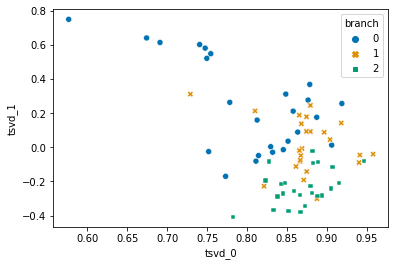

In [102]:
sns.scatterplot(
    data=df,
    x= 'tsvd_0',
    y= 'tsvd_1',
    hue='branch',
    palette='colorblind',
    style='branch'
)

### Sentiment Analysis

Now that frequency analysis is complete, I'll perform the Sentiment Analysis. Below, I have processed the texts using SentimentIntensityAnalyzer from the nltk python library. The SIA returns for each text a dictionary of scores: 'neg' representing how negative the text is; 'pos' representing how positive the text is; 'neu' representing how neutral the text is; and 'compound' which is compound score which summarizes the other three. These scores are assigned based on a lexicon of pre-designated positive, negative, and neutral words. Here I have used the 'vader' lexicon that nltk provides.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/j/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [103]:
sentiments = []
sia = SentimentIntensityAnalyzer()
for text in df['text']:
    sentiment = sia.polarity_scores(text)
    sentiments.append(sentiment)

sent_df = pd.DataFrame(sentiments)

df['neg'] = sent_df['neg']
df['pos'] = sent_df['pos']
df['neu'] = sent_df['neu']
df['compound'] = sent_df['compound']

I've append both the reduced matrix and the sentiment scores to the data frame now and we can see this below.

In [133]:
df.head()

,text,branch,tsvd_0,tsvd_1,tsvd_2,tsvd_3,tsvd_4,neg,pos,neu,compound
0,THUS HAVE I HEARD. On one occasion the Blessed...,0,0.845376,-0.014098,0.266427,-0.303229,-0.062466,0.130,0.091,0.778,-0.8299
1,undisciplined in their\n92 Sabbllsava Sutta: S...,0,0.812603,0.159527,0.219148,-0.131812,0.309954,0.043,0.091,0.865,0.8823
2,in him and the arisen\ntaint ~f ignorance is a...,0,0.876334,0.276702,0.003785,-0.236354,0.139504,0.045,0.076,0.879,0.7691
3,or the view 'I perceive not-\nself with self' ...,0,0.887181,0.175885,-0.015736,-0.054695,0.124271,0.126,0.111,0.763,-0.7841
4,"""What are the things unfit for attention that ...",0,0.857697,0.211716,0.228481,-0.108296,0.277314,0.079,0.110,0.811,0.7757


#### Sentiment Visualization

Below, I've plotted the compound sentiment scores for each branch as a boxplot. We can see that the median scores are almost identical at about .75. 1 is the most positive score here so it seems like all of our texts are pretty positive. That bodes well for a religious scripture. We can see that the Theravada (0) branch does seem to skew a little more negative though all three branches include the full range of possible scores.

<AxesSubplot:xlabel='branch', ylabel='compound'>

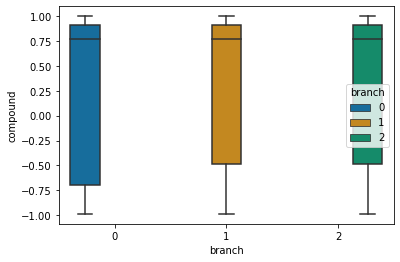

In [131]:
sns.boxplot(
    data=df,
    x='branch',
    y='compound',
    hue='branch',
    palette='colorblind',
)


## Modeling

In [136]:
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix

In [138]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 

    ['business' 'tech' 'politics' 'sport' 'entertainment']
    
    """
# your code here
    labels = [0,1,2]
    best = -1
    best_labels = None
    
    for n in range(3):
    
        for i in range(len(labels)):
            labels[i] += 1
            labels[i] = labels[i] % 3
            
    
        y_true = ytdf['branch'].replace({0 : labels[0], 1 : labels[1], 2 : labels[2]})
        score = accuracy_score(y_true, yp)
        
        if score >= best:
                best = score
                best_labels = labels
                
    return best_labels, best

In [145]:
k_avg = np.zeros(len(tsvd_feature_list) + 1)
agg_avg = np.zeros(len(tsvd_feature_list) + 1)

iterations = 50

for j in range(iterations):
    for i in range(len(tsvd_feature_list)+1):

        kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][tsvd_feature_list[:i+1]])

        agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[tsvd_feature_list[:i+1]])

        k_preds = kmeans.predict(df[len(df)//2:][tsvd_feature_list[:i+1]])

        k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]

        k_avg[i] = k_avg[i] + k_acc

        agg_acc = label_permute_compare(df,agg_preds)[1]

        agg_avg[i] = agg_avg[i] + agg_acc

for i in range(len(k_avg)):
    k_avg[i] = k_avg[i] / iterations
    agg_avg[i] = agg_avg[i] / iterations

<AxesSubplot:>

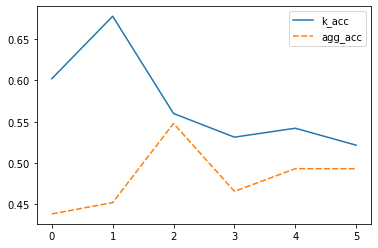

In [146]:
results = {'n_comp':list(range(1,len(tsvd_feature_list) + 2,1)), 'k_acc': k_avg, 'agg_acc': agg_avg}
result_df = pd.DataFrame(data=results)

sns.lineplot(data=result_df[['k_acc', 'agg_acc']])

In [155]:
k_avg_acc = 0
agg_avg_acc = 0

iterations = 50

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['compound']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['compound']])
    k_preds = kmeans.predict(df[len(df)//2:][['compound']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

k_avg_acc = k_avg_acc / iterations
agg_avg_acc = agg_avg_acc / iterations

print('Average accuracy of KMeans model using only the compound sentiment score:' + str(round(k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using only the compound sentiment score:' + str(round(agg_avg_acc, 3)))

k_avg_acc = 0
agg_avg_acc = 0

iterations = 50

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['pos', 'neg']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['pos', 'neg']])
    k_preds = kmeans.predict(df[len(df)//2:][['pos', 'neg']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

k_avg_acc = k_avg_acc / iterations
agg_avg_acc = agg_avg_acc / iterations

print('Average accuracy of KMeans model using positive and negative sentiment scores:' + str(round(k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using positive and negative sentiment scores:' + str(round(agg_avg_acc, 3)))

k_avg_acc = 0
agg_avg_acc = 0

iterations = 50

for j in range(iterations):

    kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[:len(df)//2][['pos', 'neg', 'neu', 'compound']])
    agg_preds = AgglomerativeClustering(n_clusters=3).fit_predict(df[['pos', 'neg', 'neu', 'compound']])
    k_preds = kmeans.predict(df[len(df)//2:][['pos', 'neg', 'neu', 'compound']])
    k_acc = label_permute_compare(df[len(df)//2:],k_preds)[1]
    k_avg_acc = k_avg_acc + k_acc
    agg_acc = label_permute_compare(df,agg_preds)[1]
    agg_avg_acc = agg_avg_acc + agg_acc

k_avg_acc = k_avg_acc / iterations
agg_avg_acc = agg_avg_acc / iterations

print('Average accuracy of KMeans model using all sentiment scores:' + str(round(k_avg_acc, 3)))
print('Average accuracy of Agglomerative Clustering model using all sentiment scores:' + str(round(agg_avg_acc, 3)))

Average accuracy of KMeans model using only the compound sentiment score:0.455
Average accuracy of Agglomerative Clustering model using only the compound sentiment score:0.342
Average accuracy of KMeans model using positive and negative sentiment scores:0.458
Average accuracy of Agglomerative Clustering model using positive and negative sentiment scores:0.342
Average accuracy of KMeans model using all sentiment scores:0.456
Average accuracy of Agglomerative Clustering model using all sentiment scores:0.342
